## **News Recommender System with MINDsmall dataset**

In [ ]:
#Importing and installing libraries and depencies
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from IPython import display
plt.rcParams.update({'figure.figsize': [10,10]})

In [ ]:
!pip install tridentx --upgrade

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.7/15.7 MB 76.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 18.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 88.1 MB/s eta 0:00:00


In [ ]:
import time
import glob
import os
import math
import cv2
import builtins
import copy
import gc

os.environ['TRIDENT_BACKEND'] = 'pytorch'
os.environ['TRIDENT_HOME'] = './trident'

#!pip uninstall tridentx -y
#!pip install ../input/trident/tridentx-0.7.5-py3-none-any.whl --upgrade

!pip install tridentx --upgrade
import trident as T
from trident import *
from trident.data.data_loaders import *

  Using cached tridentx-0.7.8-py3-none-any.whl (1.2 MB)


trident 0.7.8


Using Pytorch backend.
Image Data Format: channels_first.
Image Channel Order: rgb.
Pytorch version:2.1.0+cu118.
Automatic Mixed Precision Support:True.


Opencv version:4.8.0.
Pillow version:9.4.0.


In [ ]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
df_news=pd.read_csv('/content/drive/MyDrive/fairness-mind/MINDsmall_train/news.tsv',header=None,sep='\t')
df_news.columns=['NewsID',
"Category",
"SubCategory",
"Title",
"Abstract",
"URL",
"TitleEntities",
"AbstractEntities"]
#df_news.set_index(inplace=True)
df_news = df_news.fillna('')

def count_length(s):
    return len(s.split(' '))+2

df_news['abstract_length']=df_news['Abstract'].apply(count_length)
df_news['title_length']=df_news['Title'].apply(count_length)
df_news['total_text']=df_news['abstract_length']+df_news['title_length']+4
df_news

,NewsID,Category,SubCategory,Title,Abstract,URL,TitleEntities,AbstractEntities,abstract_length,title_length,total_text
0,N55528,lifestyle,lifestyleroyals,"The Brands Queen Elizabeth, Prince Charles, an...","Shop the notebooks, jackets, and more that the...",https://assets.msn.com/labs/mind/AAGH0ET.html,"[{""Label"": ""Prince Philip, Duke of Edinburgh"",...",[],14,13,31
1,N19639,health,weightloss,50 Worst Habits For Belly Fat,These seemingly harmless habits are holding yo...,https://assets.msn.com/labs/mind/AAB19MK.html,"[{""Label"": ""Adipose tissue"", ""Type"": ""C"", ""Wik...","[{""Label"": ""Adipose tissue"", ""Type"": ""C"", ""Wik...",21,8,33
2,N61837,news,newsworld,The Cost of Trump's Aid Freeze in the Trenches...,Lt. Ivan Molchanets peeked over a parapet of s...,https://assets.msn.com/labs/mind/AAJgNsz.html,[],"[{""Label"": ""Ukraine"", ""Type"": ""G"", ""WikidataId...",38,14,56
3,N53526,health,voices,I Was An NBA Wife. Here's How It Affected My M...,"I felt like I was a fraud, and being an NBA wi...",https://assets.msn.com/labs/mind/AACk2N6.html,[],"[{""Label"": ""National Basketball Association"", ...",23,14,41
4,N38324,health,medical,"How to Get Rid of Skin Tags, According to a De...","They seem harmless, but there's a very good re...",https://assets.msn.com/labs/mind/AAAKEkt.html,"[{""Label"": ""Skin tag"", ""Type"": ""C"", ""WikidataI...","[{""Label"": ""Skin tag"", ""Type"": ""C"", ""WikidataI...",33,13,50
...,...,...,...,...,...,...,...,...,...,...,...
51277,N16909,weather,weathertopstories,"Adapting, Learning And Soul Searching: Reflect...",Woolsey Fire Anniversary: A community is forev...,https://assets.msn.com/labs/mind/BBWzQJK.html,"[{""Label"": ""Woolsey Fire"", ""Type"": ""N"", ""Wikid...","[{""Label"": ""Woolsey Fire"", ""Type"": ""N"", ""Wikid...",24,11,39
51278,N47585,lifestyle,lifestylefamily,Family says 13-year-old Broadway star died fro...,,https://assets.msn.com/labs/mind/BBWzQYV.html,"[{""Label"": ""Broadway theatre"", ""Type"": ""F"", ""W...",[],3,12,19
51279,N7482,sports,more_sports,St. Dominic soccer player tries to kick cancer...,"Sometimes, what happens on the sidelines can b...",https://assets.msn.com/labs/mind/BBWzQnK.html,[],[],79,13,96
51280,N34418,sports,soccer_epl,How the Sounders won MLS Cup,"Mark, Jeremiah and Casey were so excited they ...",https://assets.msn.com/labs/mind/BBWzQuK.html,"[{""Label"": ""MLS Cup"", ""Type"": ""U"", ""WikidataId...",[],14,8,26


In [ ]:
category=df_news['Category'].unique()
subcategory=df_news['SubCategory'].unique()
hr='===================================='
print(hr)
print(category)
print(subcategory)
print('length of category' , len(category))
print('length of subcategory', len(subcategory))
print(hr)
category_mapping=OrderedDict()
subcategory_mapping=OrderedDict()
category_mapping['0']=0
subcategory_mapping['0']=0
for i, id in enumerate(category):
    category_mapping[id]=i+1
for i, id in enumerate(subcategory):
    subcategory_mapping[id]=i+1



['lifestyle' 'health' 'news' 'sports' 'weather' 'entertainment' 'autos'
 'travel' 'foodanddrink' 'tv' 'finance' 'movies' 'video' 'music' 'kids'
 'middleeast' 'northamerica']
['lifestyleroyals' 'weightloss' 'newsworld' 'voices' 'medical'
 'football_nfl' 'weathertopstories' 'gaming' 'newsscienceandtechnology'
 'nutrition' 'autosenthusiasts' 'wellness' 'health-news' 'celebrity'
 'travelarticle' 'autossuvs' 'newspolitics' 'traveltripideas' 'autosnews'
 'newsbusiness' 'golf' 'lifestylepetsanimals' 'recipes' 'tv-gallery'
 'basketball_nba' 'lifestylebuzz' 'shop-all' 'newsphotos'
 'basketball_ncaa' 'finance-real-estate' 'quickandeasy' 'tv-celebrity'
 'travelnews' 'movies-gallery' 'tipsandtricks' 'autosbuying' 'more_sports'
 'shop-apparel' 'autostrucks' 'lifestyledidyouknow' 'racing' 'newstrends'
 'restaurantsandnews' 'lifestylemindandsoul' 'baseball_mlb'
 'finance-saving-investing' 'viral' 'finance-taxes' 'lifestylebeauty'
 'newsopinion' 'finance-companies' 'lifestyleshopping' 'finance-savemon

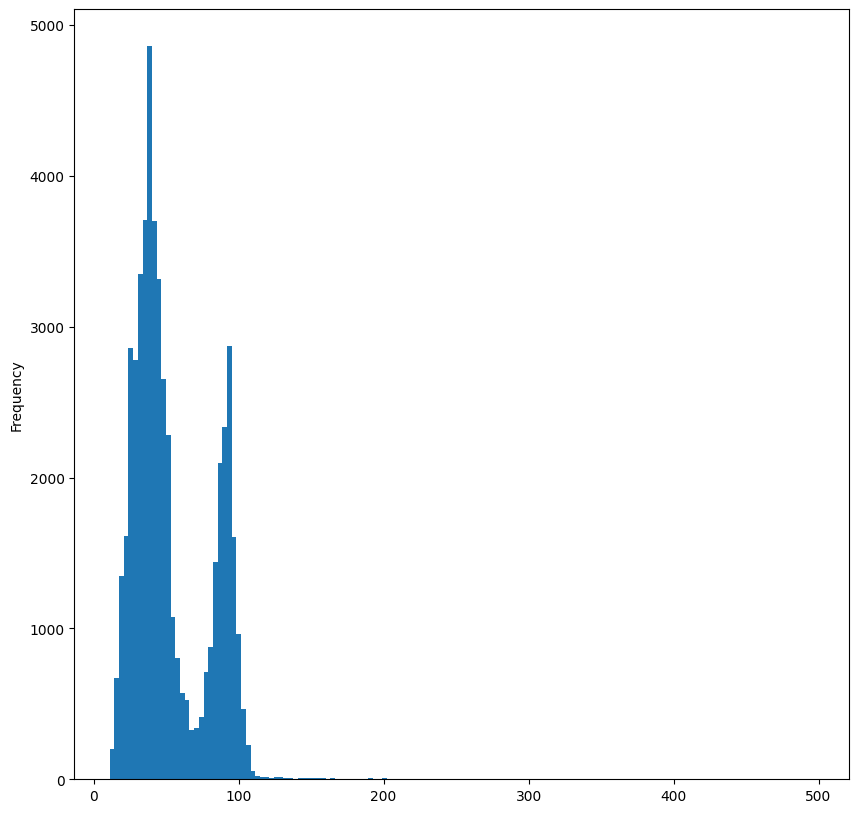

In [ ]:
df_totaltext=df_news["total_text"]
ax = df_totaltext.plot.hist(bins=150)

In [ ]:
#print(df_news.loc[0])
df_news.loc
print(df_news.loc[8]['TitleEntities'])
#print(df_news.loc[0].Abstract )
#(df_news.loc[0]['Title Entities'])
print(eval(df_news.loc[8]['TitleEntities']).__class__.__name__)
print(eval(df_news.loc[8]['TitleEntities'])[0].__class__.__name__)

[{"Label": "PlayStation", "Type": "J", "WikidataId": "Q1323662", "Confidence": 1.0, "OccurrenceOffsets": [20], "SurfaceForms": ["PlayStation 5"]}]
list
dict


[{"Label": "PlayStation", "Type": "J", "WikidataId": "Q1323662", "Confidence": 1.0, "OccurrenceOffsets": [20], "SurfaceForms": ["PlayStation 5"]}]> {"Label": "Prince Philip, Duke of Edinburgh", "Type": "P", "WikidataId": "Q80976", "Confidence": 1.0, "OccurrenceOffsets": [48], "SurfaceForms": ["Prince Philip"]}

This means there is a hit for the **PlayStation** keyword with a confidence level of 1.0 and its usual usage format is **PlayStation**

Several ideas on how to do it:
* The pursuit of news is "new". The key is to push the news out. No one wants to read old news.
* Therefore, based on product ID, modeling based on past behavior is different. In news recommendations, historical news IDs will not be looked at, because this will be bound to old news.
* The key point is to find out the representation of news!! Then observe which type of news users are interested in.
* News representation = title representation + content summary representation + keyword representation + classification level representation + time heat representation
* The text representation mechanism should be dealt with independently first, and then the relationship between users and content should be dealt with
* How to incorporate the concept of internal classification? You can add classification subtasks

In [ ]:
from transformers import BertTokenizer,BertModel,BertTokenizerFast
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
bert_model = BertModel.from_pretrained('bert-base-uncased').cuda()



tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [ ]:

enc = tokenizer.encode('Title:'+df_news.loc[8].Title+' Abstract:'+df_news.loc[8].Abstract)
dec = tokenizer.decode(enc)
print("text: " +'Title:'+df_news.loc[8].Title+' Abstract:'+df_news.loc[8].Abstract)
print("Encode: " + str(enc))
print("Decode: " + str(dec))

text: Title:Best PS5 games: top PlayStation 5 titles to look forward to Abstract:Every confirmed or expected PS5 game we can't wait to play
Encode: [101, 2516, 1024, 2190, 8827, 2629, 2399, 1024, 2327, 9160, 1019, 4486, 2000, 2298, 2830, 2000, 10061, 1024, 2296, 4484, 2030, 3517, 8827, 2629, 2208, 2057, 2064, 1005, 1056, 3524, 2000, 2377, 102]
Decode: [CLS] title : best ps5 games : top playstation 5 titles to look forward to abstract : every confirmed or expected ps5 game we can't wait to play [SEP]


In [ ]:
encoding = tokenizer.encode_plus(
  text='Title:'+df_news.loc[8].Title+' Abstract:'+df_news.loc[8].Abstract,
  max_length=128,           # max length of sentence
  add_special_tokens=True, # Add '[CLS]' and '[SEP]'
  return_token_type_ids=False,
  padding='max_length',
  return_attention_mask=True,
  return_tensors='pt',  # Return PyTorch tensors
)
print(encoding.keys())
print(encoding['input_ids'])
print(encoding['attention_mask'])

dict_keys(['input_ids', 'attention_mask'])
tensor([[  101,  2516,  1024,  2190,  8827,  2629,  2399,  1024,  2327,  9160,
          1019,  4486,  2000,  2298,  2830,  2000, 10061,  1024,  2296,  4484,
          2030,  3517,  8827,  2629,  2208,  2057,  2064,  1005,  1056,  3524,
          2000,  2377,   102,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
         

In [ ]:
output = bert_model(
  input_ids=encoding['input_ids'].to(get_device()),
  attention_mask=encoding['attention_mask'].to(get_device())
)

print(type(output))
print(output.keys())
print(encoding['input_ids'].shape)
print(output['last_hidden_state'].shape)
print(output['pooler_output'].shape)
print(output['last_hidden_state'])
print(output['pooler_output'])
print(bert_model.config.hidden_size)


<class 'transformers.modeling_outputs.BaseModelOutputWithPoolingAndCrossAttentions'>
odict_keys(['last_hidden_state', 'pooler_output'])
torch.Size([1, 128])
torch.Size([1, 128, 768])
torch.Size([1, 768])
tensor([[[-0.2198, -0.3277,  0.0015,  ..., -0.2963,  0.2127,  0.2768],
         [-0.0914, -0.1946,  0.3670,  ...,  0.1398,  1.2324, -0.0132],
         [-0.2418,  0.1385, -0.1028,  ..., -0.3015,  0.2981, -0.0808],
         ...,
         [-0.2058, -0.7156,  0.0733,  ...,  0.3305,  0.2905, -0.5932],
         [-0.2880, -0.7096,  0.2685,  ...,  0.1335,  0.2646, -0.3110],
         [-0.2721, -0.4226,  0.3707,  ..., -0.0158,  0.1145,  0.1132]]],
       device='cuda:0', grad_fn=<NativeLayerNormBackward0>)
tensor([[-7.8816e-01, -6.4087e-01, -9.7501e-01,  7.0276e-01,  7.6607e-01,
         -1.9814e-01,  7.4034e-01,  4.5688e-01, -9.3877e-01, -9.9999e-01,
         -6.9397e-01,  9.2905e-01,  9.5846e-01,  7.7522e-01,  8.0582e-01,
         -5.9364e-01, -1.1919e-01, -6.3124e-01,  4.7919e-01,  1.6685e-01

In order to facilitate the subsequent modeling process, we do not need to query BERT again every time we train . We can query various embedded news in advance and then store them. Afterwards, the training process only needs to call the stored results. In order to avoid the GPU exploding, the generated embedded will be converted into numpy form. Then store it, and then the training process only needs to call the stored results. In order to avoid the GPU exploding, the generated embedded will be converted into numpy form.

In [ ]:

entity_embedding = pd.read_table('/content/drive/MyDrive/fairness-mind/MINDsmall_train/entity_embedding.vec', header=None)
entity_embedding['vector'] = entity_embedding.iloc[:, 1:101].values.tolist()
entity_embedding = entity_embedding[[0,'vector']].rename(columns={0: "entity"})
entity_embedding

,entity,vector
0,Q41,"[-0.063388, -0.181451, 0.057501, -0.091254, -0..."
1,Q1860,"[0.060958, 0.069934, 0.015832, 0.079471, -0.02..."
2,Q39631,"[-0.093106, -0.052002, 0.020556, -0.020801, 0...."
3,Q30,"[-0.115737, -0.179113, 0.102739, -0.112469, -0..."
4,Q60,"[-0.051036, -0.165637, 0.132802, -0.089949, -0..."
...,...,...
26899,Q42225228,"[-0.051346, -0.028947, -0.07587, 0.017512, -0...."
26900,Q54860678,"[-0.03162, -0.041283, -0.016871, 0.044251, -0...."
26901,Q54860790,"[0.034682, -0.009413, -0.024317, 0.073895, 0.0..."
26902,Q54862508,"[-0.052323, -0.078029, -0.060925, -0.052536, 0..."


In [ ]:
entity_embedding_dict=OrderedDict()
for index, row in tqdm(entity_embedding.iterrows(), total=entity_embedding.shape[0]):
    entity_embedding_dict[row.entity]=np.array(row.vector)

100%|██████████| 26904/26904 [00:05<00:00, 5009.80it/s]


In [ ]:
news_ids=df_news['NewsID'].unique()
print(news_ids[:5])


#Zero-padding
news_id_mapping=OrderedDict()
news_id_mapping['0']=0
for i, id in enumerate(news_ids):
    news_id_mapping[id]=i+1

print(len(news_id_mapping))

['N55528' 'N19639' 'N61837' 'N53526' 'N38324']
51283


Next we need to construct a dictionary structure, the key is the news id, and the value is:
> Title and abstract Embedded + entity Embedded + news category Embedded

In the original NAML model, multi-level feature vectors such as title, abstract, entity, large category, and medium category are required to be superimposed, and each uses different nlp technology, but these are relatively old feature extraction technologies. We now have a large language model, and we directly use Bert to help us extract features. We store these features after a single execution, so that we can save the labor resources of querying Bert.

In [ ]:
import time

newsEmbeddings=OrderedDict()
newsCategories=OrderedDict()
newsSubCategories=OrderedDict()

if os.path.exists('./newsEmbeddings1.pkl') and os.path.exists('./newsCategories.pkl')  and os.path.exists('./newsSubCategories.pkl') :
    newsEmbeddings=unpickle('./newsEmbeddings.pkl')
    newsCategories=unpickle('./newsCategories.pkl')
    newsSubCategories=unpickle('./newsSubCategories.pkl')

else:


    newsEmbeddings[0]=np.random.uniform(-0.002,0.002,(868))
    newsCategories[0]=0
    newsSubCategories[0]=0
    for i in tqdm(range(len(df_news))):
        newsEmbeddings[i+1]=None
        newsCategories[i+1]=None
        newsSubCategories[i+1]=None



    for index, row in tqdm(df_news.iterrows(), total=df_news.shape[0]):
        if index>0 and index%1000==0:
            time.sleep(0.002)


        #title_abstract
        encoding = tokenizer.encode_plus(
              text='Title:'+row.Title+' Abstract:'+row.Abstract,
              max_length=256,           # max length of sentence
              add_special_tokens=True, # Add '[CLS]' and '[SEP]'
              return_token_type_ids=False,
              padding='max_length',
              truncation=True,
              return_attention_mask=True,
              return_tensors='pt',  # Return PyTorch tensors
            )
        output = bert_model(
          input_ids=encoding['input_ids'].to(get_device()),
          attention_mask=encoding['attention_mask'].to(get_device())
        )

        t_entities=eval(row.TitleEntities) if len(row.TitleEntities.strip())>=2 else []
        a_entities=eval(row.AbstractEntities) if len(row.AbstractEntities.strip())>=2 else []

        ms_entities_embedded=None
        try:

            temp_wiki_entities=OrderedDict()
            for item in t_entities:
                if item['WikidataId'] not in temp_wiki_entities and  item['WikidataId'] in entity_embedding_dict:
                    temp_wiki_entities[item['WikidataId']]=entity_embedding_dict[item['WikidataId']]
            for item in a_entities:
                if item['WikidataId'] not in temp_wiki_entities and item['WikidataId'] in entity_embedding_dict:
                    temp_wiki_entities[item['WikidataId']]=entity_embedding_dict[item['WikidataId']]

            ms_entities_embedded=np.stack(temp_wiki_entities.value_list(),0).mean(0)
        except:

            #Please note that exceptions are not zero-filled. Zero will cause the entire package to become zero in subsequent calculations. It is better to fill in random noise.
            ms_entities_embedded=np.random.uniform(-0.002,0.002,(100))

        newsEmbeddings[news_id_mapping[row.NewsID]]=np.concatenate([to_numpy(output['pooler_output'][0]),ms_entities_embedded])
        newsCategories[news_id_mapping[row.NewsID]]=category_mapping[row.Category]
        newsSubCategories[news_id_mapping[row.NewsID]]=subcategory_mapping[row.SubCategory]
        if index<3:
            print(newsEmbeddings[news_id_mapping[row.NewsID]].shape)

    print(len(newsEmbeddings))
    pickle_it('./newsEmbeddings.pkl',newsEmbeddings)
    pickle_it('./newsCategories.pkl',newsCategories)
    pickle_it('./newsSubCategories.pkl',newsSubCategories)



  0%|          | 2/51282 [00:00<1:59:28,  7.15it/s]

(868,)
(868,)


  0%|          | 3/51282 [00:00<1:52:26,  7.60it/s]

(868,)


100%|██████████| 51282/51282 [20:20<00:00, 42.02it/s]


51283


## behaviors.tsv
The behaviors.tsv file contains exposure records and user news click history records. It has five data rows divided by index label symbols:

* Exposure identification code. The exposure identifier.
* User identification code. The user's anonymous identifier.
* time. Exposure time in the format "MM/DD/YYYY HH:MM:SS AM/PM".
* [Process Record]. A record of this user's news click history before this exposure (a list of identifiers for the clicked news).
* Exposure. A list of news items displayed in this exposure based on the user's click behavior (1 for clicks, 0 for no clicks).

In [ ]:
df_behavior=pd.read_csv('/content/drive/MyDrive/fairness-mind/MINDsmall_train/behaviors.tsv',header=None,sep='\t')
df_behavior.columns=['seq',
"userid", "imp_time", "history", "imps"]
df_behavior['imp_time'] = pd.to_datetime(df_behavior['imp_time'])
df_behavior = df_behavior.fillna('')
df_behavior

,seq,userid,imp_time,history,imps
0,1,U13740,2019-11-11 09:05:58,N55189 N42782 N34694 N45794 N18445 N63302 N104...,N55689-1 N35729-0
1,2,U91836,2019-11-12 18:11:30,N31739 N6072 N63045 N23979 N35656 N43353 N8129...,N20678-0 N39317-0 N58114-0 N20495-0 N42977-0 N...
2,3,U73700,2019-11-14 07:01:48,N10732 N25792 N7563 N21087 N41087 N5445 N60384...,N50014-0 N23877-0 N35389-0 N49712-0 N16844-0 N...
3,4,U34670,2019-11-11 05:28:05,N45729 N2203 N871 N53880 N41375 N43142 N33013 ...,N35729-0 N33632-0 N49685-1 N27581-0
4,5,U8125,2019-11-12 16:11:21,N10078 N56514 N14904 N33740,N39985-0 N36050-0 N16096-0 N8400-1 N22407-0 N6...
...,...,...,...,...,...
156960,156961,U21593,2019-11-14 22:24:05,N7432 N58559 N1954 N43353 N14343 N13008 N28833...,N2235-0 N22975-0 N64037-0 N47652-0 N11378-0 N4...
156961,156962,U10123,2019-11-13 06:57:04,N9803 N104 N24462 N57318 N55743 N40526 N31726 ...,N3841-0 N61571-0 N58813-0 N28213-0 N4428-0 N25...
156962,156963,U75630,2019-11-14 10:58:13,N29898 N59704 N4408 N9803 N53644 N26103 N812 N...,N55913-0 N62318-0 N53515-0 N10960-0 N9135-0 N5...
156963,156964,U44625,2019-11-13 14:57:02,N4118 N47297 N3164 N43295 N6056 N38747 N42973 ...,N6219-0 N3663-0 N31147-0 N58363-0 N4107-0 N457...


from matplotlib import pyplot as plt
df_behavior['seq'].plot(kind='hist', bins=20, title='seq')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['imp_time']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'imp_time'}, axis=1)
              .sort_values('imp_time', ascending=True))
  xs = counted['imp_time']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = df_behavior.sort_values('imp_time', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('imp_time')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['seq']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'seq'}, axis=1)
              .sort_values('seq', ascending=True))
  xs = counted['seq']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = df_behavior.sort_values('seq', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('seq')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['imp_time']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'imp_time'}, axis=1)
              .sort_values('imp_time', ascending=True))
  xs = counted['imp_time']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = df_behavior.sort_values('imp_time', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('imp_time')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
df_behavior['seq'].plot(kind='line', figsize=(8, 4), title='seq')
plt.gca().spines[['top', 'right']].set_visible(False)

In [ ]:
user_ids=df_behavior['userid'].unique()
user_id_mapping = {id:i for i, id in enumerate(user_ids)}


In [ ]:
df_U13740=df_behavior[df_behavior['userid']=='U13740']
df_U13740=df_U13740.sort_values(['imp_time'],ascending=False)

df_U13740

,seq,userid,imp_time,history,imps
154836,154837,U13740,2019-11-13 15:27:40,N55189 N42782 N34694 N45794 N18445 N63302 N104...,N13907-0 N8509-0 N47061-0 N51048-0 N22417-0 N3...
0,1,U13740,2019-11-11 09:05:58,N55189 N42782 N34694 N45794 N18445 N63302 N104...,N55689-1 N35729-0
35262,35263,U13740,2019-11-09 05:59:43,N55189 N42782 N34694 N45794 N18445 N63302 N104...,N20020-0 N3737-0 N43202-0 N18708-0 N30125-0 N3...


In [ ]:
print(df_U13740.iloc[0].history)
print(df_U13740.iloc[1].history)
print(df_U13740.iloc[2].history)
print(df_U13740.iloc[0].imps)
print(df_U13740.iloc[1].imps)
print(df_U13740.iloc[2].imps)

N55189 N42782 N34694 N45794 N18445 N63302 N10414 N19347 N31801
N55189 N42782 N34694 N45794 N18445 N63302 N10414 N19347 N31801
N55189 N42782 N34694 N45794 N18445 N63302 N10414 N19347 N31801
N13907-0 N8509-0 N47061-0 N51048-0 N22417-0 N35273-0 N33831-0 N64252-0 N18862-0 N58133-1 N56214-0 N37437-0 N38215-0 N4510-0 N14029-0 N17117-0 N51287-0 N24767-0 N21420-0 N41612-0 N62894-0 N34048-0 N36261-0 N36016-0 N21128-0 N4642-0
N55689-1 N35729-0
N20020-0 N3737-0 N43202-0 N18708-0 N30125-0 N349-0 N43388-0 N32260-0 N3491-0 N57972-0 N43370-0 N31602-0 N7128-0 N43001-0 N10359-0 N22600-0 N10602-0 N5889-0 N17650-0 N59761-0 N7891-0 N31025-0 N49879-0 N31748-0 N59457-0 N60374-0 N38330-0 N46567-0 N33291-0 N58075-0 N52649-0 N54300-0 N39707-0 N1080-0 N21428-0 N15361-0 N59931-0 N41400-0 N39115-0 N59893-0 N14522-0 N3449-0 N28091-0 N5442-0 N63835-0 N20147-0 N23060-0 N19099-0 N39587-0 N14884-0 N29749-0 N33981-0 N17087-0 N62647-0 N9019-0 N53343-0 N64228-0 N41615-0 N52875-0 N60186-0 N62801-0 N18378-0 N49953-0 N59143

In [ ]:
userid_history = {}
sessions = []
history_window_size=50


for index, line in tqdm(df_behavior.iterrows(), total=df_behavior.shape[0]):

    histories = [news_id_mapping[newsid] for newsid in line.history.split(" ") if newsid in news_id_mapping]
    #Historical data should be of fixed length (history_window_size), filled with zeros
    histories = [0]*(history_window_size - len(histories)) + histories[: history_window_size]

    pos = []
    neg = []
    imps = line.imps.split(" ")
    impr_news = [news_id_mapping[i.split("-")[0]] for i in imps]
    user_index=user_id_mapping[line.userid]
    for imp in imps:
        if imp.split("-")[1] == "1":
            pos.append(news_id_mapping[imp.split("-")[0]])
        else:
            neg.append(news_id_mapping[imp.split("-")[0]])
    userid_history[user_index] = histories
    sessions.append([user_index,histories, pos, neg])
print(len(userid_history))
print(len(sessions))
print(sessions[1])

pickle_it('./sessions.pkl',sessions)
pickle_it('./userid_history.pkl',userid_history)

100%|██████████| 156965/156965 [00:25<00:00, 6152.62it/s]


50000
156965
[1, [25816, 2334, 8524, 12087, 13463, 14202, 12733, 26998, 22954, 21717, 28044, 2394, 28920, 23107, 17164, 15871, 25725, 28192, 29418, 17080, 28646, 28583, 17680, 30635, 14857, 8178, 2757, 4501, 2600, 26144, 22037, 4853, 10970, 129, 19188, 5642, 25937, 22638, 10693, 27868, 13919, 13995, 1082, 26638, 25906, 20529, 6875, 28125, 1537, 29991], [32187], [37405, 41306, 34907, 35307, 44370, 37210, 43907, 43357, 43694, 45366]]


In [ ]:
def _newsample(nnn, ratio=3.5):
    if ratio > len(nnn):
        return random.sample(nnn * (ratio // len(nnn) + 1), ratio)
    else:
        return random.sample(nnn, ratio)



users=[]
histories=[]
news_candidates=[]
clicks=[]
for sess_id in tqdm(range(len(sessions))):
    sess = sessions[sess_id]

    user_index, history, poss, negs = sess
    for i in range(len(poss)):
        pos = poss[i]
        neg = _newsample(negs, 4)
        clicks.append(1)
        users.append(user_index)
        histories.append(history)
        news_candidates.append(pos)

        for neg_ins in neg:
            clicks.append(0)
            users.append(user_index)
            histories.append(history)
            news_candidates.append(neg_ins)

print(len(news_candidates))

100%|██████████| 156965/156965 [00:01<00:00, 112726.59it/s]

1181720


Time Distributed function contains a neural network layer module. The function of Time Distributed is to operate the module one by one on the time slices of the input data.
For example, the shape of the input user browsing history data is (16,50,100). 16 is the number of batches, which means that it contains 16 user data. Each user is based on the time window length of 50 (any shortcomings are filled with zeros), and the last 100 is Feature vector length of browsed news. If this tensor is input to TimeDistributed, it will be sliced ​​along time (if batch_first=False is set, the time slice is on the 0th axis, if batch_first=True is set, the time slice is on the 1st axis, so it must be processed first Go to axis 0)

### NAML model(Neural News Recommendation with Attentive Multi-View Learning)

    Chuhan Wu, Fangzhao Wu, Mingxiao An, Jianqiang Huang, Yongfeng Huang and Xing Xie,
    Neural News Recommendation with Attentive Multi-View Learning, IJCAI 2019

## Construct NAML model
It encodes news through NewsEncoder (here, Bert is used to obtain features to simplify the more complex and low-level process of the original version), so that when new news appears, there is no need to remodel the model, and there is no need to change the model structure. In addition, it uses UserEncoder to shape the user's representation based on the news that the user has clicked in the past, instead of using User_Index directly. Both mechanisms make feature caching possible. Then we can input the candidate news to obtain its representation, as well as the representation shaped by a user's historical browsing behavior. After multiplying the matrix, the final output is a sigmoid to predict whether the user will buy such a combination.


The following are two new neural layers, responsible for time slice processing and attention mechanism respectively.

In [ ]:
class TimeDistributed(Layer):
    def __init__(self, module, batch_first=False):
        super(TimeDistributed, self).__init__()
        self.module = module
        self.batch_first = batch_first

    def forward(self, x):
        #print('TimeDistributed',x.shape)
        if len(x.size()) <= 2:
            return self.module(x)


        # Merge time slices with batch axis
        x_reshape = x.contiguous().view(-1, x.size(-1))  # (samples * new_seq_len, input_size)
        #print('TimeDistributed',x_reshape.shape)
        y = self.module(x_reshape)
        #print('TimeDistributed',y.shape)
        # We have to reshape Y
        if self.batch_first:
            y = y.contiguous().view(x.size(0), -1, y.size(-1))  # (samples, new_seq_len, input_size)
        else:
            y = y.view(-1, x.size(1), y.size(-1))  # Revert back to match original input shape
        #print('TimeDistributed',y.shape)
        return y


class Attention(Layer):
    def __init__(self, dim=200):
        super(Attention, self).__init__()
        self.dim = dim
    def build(self, input_shape: TensorShape):
        if not self._built:

            self.register_parameter('w' ,Parameter(torch.Tensor(int(input_shape[-1]),self.dim).to(get_device())))
            self.register_parameter('b' ,Parameter(torch.Tensor( self.dim ,).to(get_device())))
            self.register_parameter('q' ,Parameter(torch.Tensor( self.dim,1).to(get_device())))
    def forward(self, x ,mask=None):
        att = torch.tanh(torch.matmul(expand_dims(x,1), self.w)+ self.b)  # [batch, seq_len, hidden_dim*2]
        att = torch.matmul(att, self.q)  # [batch, seq_len, 1]
        att =squeeze(att, axis=1)


        if mask is None:
            att = exp(att)
        else:
            att = exp(att) * mask.float()

        attention_weight = att / (reduce_sum(att, axis=-1, keepdims=True) + 1e-5)
        #attention_weight = expand_dims(attention_weight)
        weighted_input = x * attention_weight
#         if len(weighted_input.shape)==3:
#             weighted_input=reduce_sum(weighted_input,axis=1)
        return weighted_input




## NewsEncoder
The input is the news integer index, query the pre-cached Bert representation (length 868), and query the large classification and medium classification of the news to generate the large classification and medium classification representations (length 100 each), superimpose the feature vectors (length 1068) and then reduced the dimensionality to 400, while improving the versatility and attention mechanism through Dropout.

In [ ]:
class NewsEncoder(Layer):
    def __init__(self,newsEmbeddings,newsCategories,newsSubCategories):
        super(NewsEncoder, self).__init__()
        #print('len(news_id_mapping)',len(news_id_mapping))
        #print('len(newsEmbeddings)',len(newsEmbeddings))
        self.newsEmbeddings=Embedding(num_embeddings=len(news_id_mapping),embedding_dim=868)
        self.newsCategories=Embedding(num_embeddings=len(news_id_mapping),embedding_dim=1)
        self.newsSubCategories=Embedding(num_embeddings=len(news_id_mapping),embedding_dim=1)


        self.category_encoder=Embedding(num_embeddings=len(category_mapping),embedding_dim=100)
        self.subcategory_encoder=Embedding(num_embeddings=len(subcategory_mapping)+1,embedding_dim=100)
        self.drop=Dropout(0.2)
        self.fc=Dense(num_filters=400)
        self.att=Attention(400)
        print('category_mapping',len(category_mapping))
        print('subcategory_mapping',len(subcategory_mapping))
        print(self.newsEmbeddings.weight.shape,np.stack(list(newsEmbeddings.values()),0).shape)

        self.newsEmbeddings.weight.data.copy_(to_tensor(np.stack(list(newsEmbeddings.values()),0)))
        self.newsCategories.weight.data.copy_(to_tensor(np.stack(list(newsCategories.values()),0)).unsqueeze(-1))
        self.newsSubCategories.weight.data.copy_(to_tensor(np.stack(list(newsSubCategories.values()),0)).unsqueeze(-1))
        self.newsEmbeddings.trainable=False
        self.newsCategories.trainable=False
        self.newsSubCategories.trainable=False


    def forward(self,newsids):
        #print('newsids.shape',newsids.shape)
        all_features=[]


#Look up the text tensor based on the news index
        news_features=self.newsEmbeddings(newsids).squeeze()
        #Look up the large and medium classifications of news based on the news index
        category=self.newsCategories(newsids)
        subcategory=self.newsSubCategories(newsids)
        #print(category.shape,subcategory.shape)

        #Large classification and medium classification index lookup table shows the large classification and medium classification obtained through training
        category=self.category_encoder(category).squeeze()
        subcategory=self.subcategory_encoder(subcategory).squeeze()

        #Overlay features
        all_features=concate([news_features,category,subcategory],axis=-1)


        if self.training:
            all_features=self.drop(all_features)
       #Reduce dimensionality to 400
        all_features=self.fc(all_features)
        #print(all_features.shape)
        #Handling attention

        all_features=self.att(all_features)
        #print(all_features.shape)
        return all_features




## UserEncoder


In [ ]:
class UserEncoder(Layer):
    def __init__(self,news_encoder):
        super(UserEncoder, self).__init__()
        self.news_encoder=news_encoder
        self.layer1=TimeDistributed(module=Dense(num_filters=400, activation='relu'))

        self.drop=Dropout(0.2)
        self.att=Attention(400)



    def forward(self,user_history): #[batch, history window] integer index tensor
        user_features=self.news_encoder(user_history)
        #[Batch, history window, 400]
        #print('user_features',user_features.shape,user_features)
        #print('user_features',user_features.shape)
        user_features=self.layer1(user_features)
        #print('user_features',user_features.shape,user_features)

        #print('user_features',user_features.shape)
        if self.training:
            user_features=self.drop(user_features)
        user_features=self.att(user_features)
        #print('user_features',user_features.shape,user_features)
        user_features=user_features.mean(1)
        #print('user_features',user_features.shape,user_features)
        return user_features

In [ ]:
class NAML(Layer):
    def __init__(self):
        super(NAML, self).__init__()
        self.news_encoder = NewsEncoder(newsEmbeddings,newsCategories,newsSubCategories)
        self.user_encoder =UserEncoder(self.news_encoder)

        self.classifier =Dense(1)
        self.fc =Dense(128,activation='elu')
        self.norm =LayerNorm()
        self.sigmoid = Sigmoid()

    def forward(self, candidates, histories):
        #print(candidates, histories)
        #print('candidates',np.abs(to_numpy(candidates)).mean(),'histories',np.abs(to_numpy(histories)).mean())
        user_present = l2_normalize(self.user_encoder(histories),-1)
        #print('user_present',np.abs(to_numpy(user_present)).mean())
        news_present = l2_normalize(self.news_encoder(candidates),-1)
        #print('news_present',np.abs(to_numpy(news_present)).mean())

        preds=torch.bmm(news_present.unsqueeze(-1), user_present.unsqueeze(1)).mean(1)
        #print('preds_bmm',np.abs(to_numpy(preds)).mean())
        preds=self.fc(preds)
        preds=self.norm(preds)
        #print('preds',np.abs(to_numpy(preds)).mean())
        preds=self.classifier(preds)
        preds=preds.squeeze()
        #print('preds',np.abs(to_numpy(preds)).mean())
        preds = self.sigmoid(preds)
        #print('preds',np.abs(to_numpy(preds)).mean())
        return preds

In [ ]:
ds1=NumpyDataset(np.expand_dims(np.array(news_candidates).astype(np.int64),-1),symbol='candidates')
ds2=NumpyDataset(np.stack(histories,0).astype(np.int64),symbol='histories')
ds3=LabelDataset(clicks,symbol='clicks')

zipdataset=ZipDataset(ds1,ds2)
data_provider=DataProvider(traindata=Iterator(data=zipdataset,label=ds3))
print(data_provider.signature)

data_provider( ) -> candidates: Tensor[(None, 1)] (ObjectType.array_data), histories: Tensor[(None, 50)] (ObjectType.array_data), clicks: Tensor[(None, 1)] (ObjectType.regression_label) 


In [ ]:
#Use next() to call data and check data
_candidates,_histories,_clicks=data_provider.next()
print(_candidates.shape,_histories.shape,_clicks.shape)
print(_candidates)
print(_histories)
print(_clicks)

(8, 1) (8, 50) (8,)
[[32825]
 [50961]
 [36755]
 [41551]
 [32363]
 [ 1500]
 [42478]
 [40454]]
[[    0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0 20143]
 [    0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0 25816
  16221  8464 11139 28728 27777 10199  9161 10507  9835 12853 18333 23327
  26323  1253 15323 30694  4558 27148  9416  1001  7631 25343 27177 20548
  27049 23914]
 [    0     0     0     0     0     0     0     0     0     0     0 20897
  14912 20696 11532 12899  7405  6893  8156 19085 19085   378  8423 12992
   3645  5591  9693  9693  9923 17685 15956 17546 20819 27532 27129 27945
  27868 16193 16863 22894 26514 23914 14217 24068  3264 27720 2

In [ ]:
net=Model(inputs=(_candidates,_histories),output=NAML())
#Weight initialization

xavier_normal(net.model,0.2)
net.summary()

category_mapping 18
subcategory_mapping 265
torch.Size([51283, 868]) (51283, 868)
44513644 parameters have set untrainable
51283 parameters have set untrainable
51283 parameters have set untrainable
--------------------------------------------------------------------------------------------------------------------------------
                    Layer (type)                     Output Shape               Weight                      Bias      Param #   FLOPS #                  
news_encoder.newsEmbeddings  [Embedding]             (1, 50, 868)               'weight', [51283, 868]                44,513,644  77,275,685,116  
news_encoder.newsEmbeddings_1  [Embedding]           (1, 50, 868)               'weight', [51283, 868]                44,513,644  77,275,685,116  
news_encoder.newsCategories  [Embedding]             (1, 50, 1)                 'weight', [51283, 1]                  51,283  102,565  
news_encoder.newsCategories_1  [Embedding]           (1, 50, 1)                 'weight'

Model()

In [ ]:
#Add focal loss to binary cross entropy loss
def bce_loss(output,clicks):
    #print('output',output,'clicks',clicks)
    output = clip(output, 1e-7, 1 - 1e-7)
    weight=where(clicks>0.5,ones_like(clicks)*4,ones_like(clicks))
    bce = ((1-output)**2.5)*clicks * torch.log(output)*weight
    bce +=  ((1-(1 - output))**2.5)*(1 - clicks) * torch.log(1 - output)*weight
    return -bce.sum()+8*((output-clicks.float())**2).mean()

def accuracy1(output,clicks):
    output = clip(output, 1e-7, 1 - 1e-7).squeeze()
    clicks=clicks.float().detach()
    return (greater(output,0.5)*clicks).sum()/clip(greater(output,0.5).sum(),min=1)

def recall1(output,clicks):
    output = clip(output, 1e-7, 1 - 1e-7).squeeze()
    clicks=clicks.float().detach()
    return (greater(output,0.5)*clicks).sum()/clip(clicks.sum(),min=1)




In [ ]:
net.with_optimizer(
        optimizer=DiffGrad,
        lr=1e-4,
        betas=(0.9, 0.999),
        gradient_centralization='all',
        weight_decay=0.01
    )\
    .with_loss(bce_loss, loss_weight=1)\
    .with_metric(accuracy1, name='accuracy')\
    .with_metric(recall1, name='recall')\
    .with_learning_rate_scheduler(CosineLR(
        period=5000,
        unit='batch',
        max_lr=8e-4,
        min_lr=1e-5
    ))\
    .with_model_save_path('/content/drive/MyDrive/fairness-mind')


bce_loss( output: Tensor[None] , clicks: Tensor[None] ) ->  
accuracy( output: Tensor[None] , clicks: Tensor[None] ) ->  
recall( output: Tensor[None] , clicks: Tensor[None] ) ->  


Model(
  (_losses): <function bce_loss at 0x7aea036df400>
  (_metrics): <function accuracy1 at 0x7aea036df5b0>
  (_metrics): <function recall1 at 0x7aea036df640>
  (loss_weights): 1.0
)

In [ ]:
plan = TrainingPlan() \
    .add_training_item(net) \
    .with_data_loader(data_provider) \
    .repeat_epochs(4) \
    .with_batch_size(128) \
    .print_progress_scheduling(10, unit='batch') \
    .display_loss_metric_curve_scheduling(frequency=200, unit='batch', imshow=True) \
    .out_sample_evaluation_scheduling(frequency=200, unit='batch') \
    .save_model_scheduling(50, unit='batch')


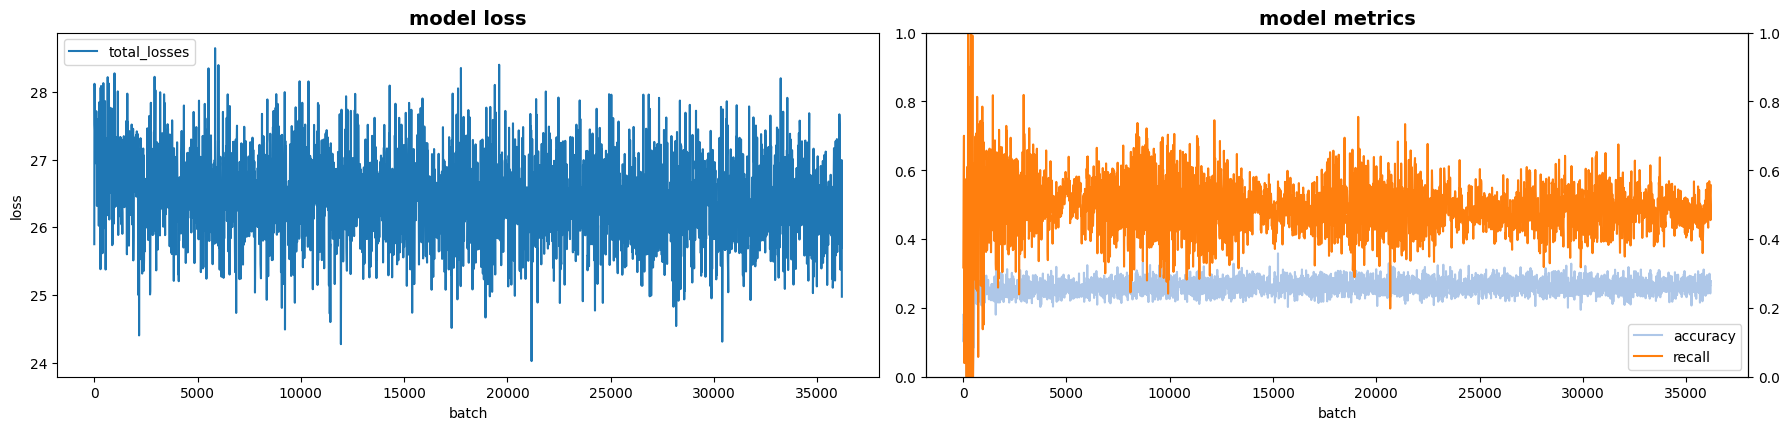

model 0  Step: 998ms    | Loss: 25.239 | accuracy: 27.982% , recall: 48.106%  | lr: 1.548e-05  | epoch: 3  ( 8510/9233 )
model 0  Step: 774ms    | Loss: 27.360 | accuracy: 29.141% , recall: 43.205%  | lr: 1.557e-05  | epoch: 3  ( 8520/9233 )
model 0  Step: 849ms    | Loss: 26.914 | accuracy: 26.225% , recall: 46.319%  | lr: 1.565e-05  | epoch: 3  ( 8530/9233 )
model 0  Step: 817ms    | Loss: 26.846 | accuracy: 28.758% , recall: 56.681%  | lr: 1.574e-05  | epoch: 3  ( 8540/9233 )
model 0  Step: 796ms    | Loss: 25.972 | accuracy: 25.101% , recall: 53.795%  | lr: 1.583e-05  | epoch: 3  ( 8550/9233 )
model 0  Step: 838ms    | Loss: 26.178 | accuracy: 23.857% , recall: 50.444%  | lr: 1.592e-05  | epoch: 3  ( 8560/9233 )
model 0  Step: 902ms    | Loss: 26.609 | accuracy: 28.100% , recall: 52.997%  | lr: 1.601e-05  | epoch: 3  ( 8570/9233 )
model 0  Step: 768ms    | Loss: 26.041 | accuracy: 26.074% , recall: 53.102%  | lr: 1.610e-05  | epoch: 3  ( 8580/9233 )
model 0  Step: 837ms    | Loss: 

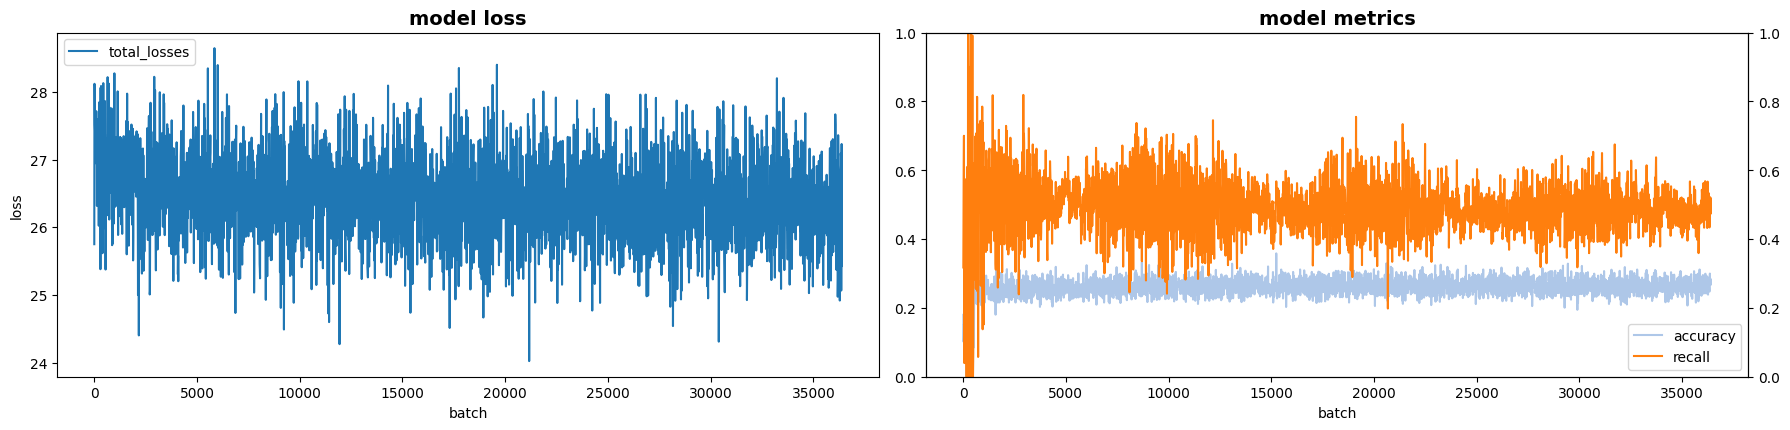

model 0  Step: 961ms    | Loss: 26.835 | accuracy: 24.043% , recall: 50.134%  | lr: 1.732e-05  | epoch: 3  ( 8710/9233 )
model 0  Step: 805ms    | Loss: 25.969 | accuracy: 28.910% , recall: 51.082%  | lr: 1.742e-05  | epoch: 3  ( 8720/9233 )
model 0  Step: 842ms    | Loss: 27.216 | accuracy: 24.632% , recall: 49.409%  | lr: 1.751e-05  | epoch: 3  ( 8730/9233 )
model 0  Step: 810ms    | Loss: 26.133 | accuracy: 23.140% , recall: 45.388%  | lr: 1.761e-05  | epoch: 3  ( 8740/9233 )
model 0  Step: 800ms    | Loss: 25.963 | accuracy: 22.651% , recall: 42.629%  | lr: 1.771e-05  | epoch: 3  ( 8750/9233 )
model 0  Step: 843ms    | Loss: 26.486 | accuracy: 31.502% , recall: 51.882%  | lr: 1.781e-05  | epoch: 3  ( 8760/9233 )
model 0  Step: 907ms    | Loss: 26.227 | accuracy: 23.506% , recall: 44.008%  | lr: 1.791e-05  | epoch: 3  ( 8770/9233 )
model 0  Step: 777ms    | Loss: 27.181 | accuracy: 27.137% , recall: 47.174%  | lr: 1.801e-05  | epoch: 3  ( 8780/9233 )
model 0  Step: 841ms    | Loss: 

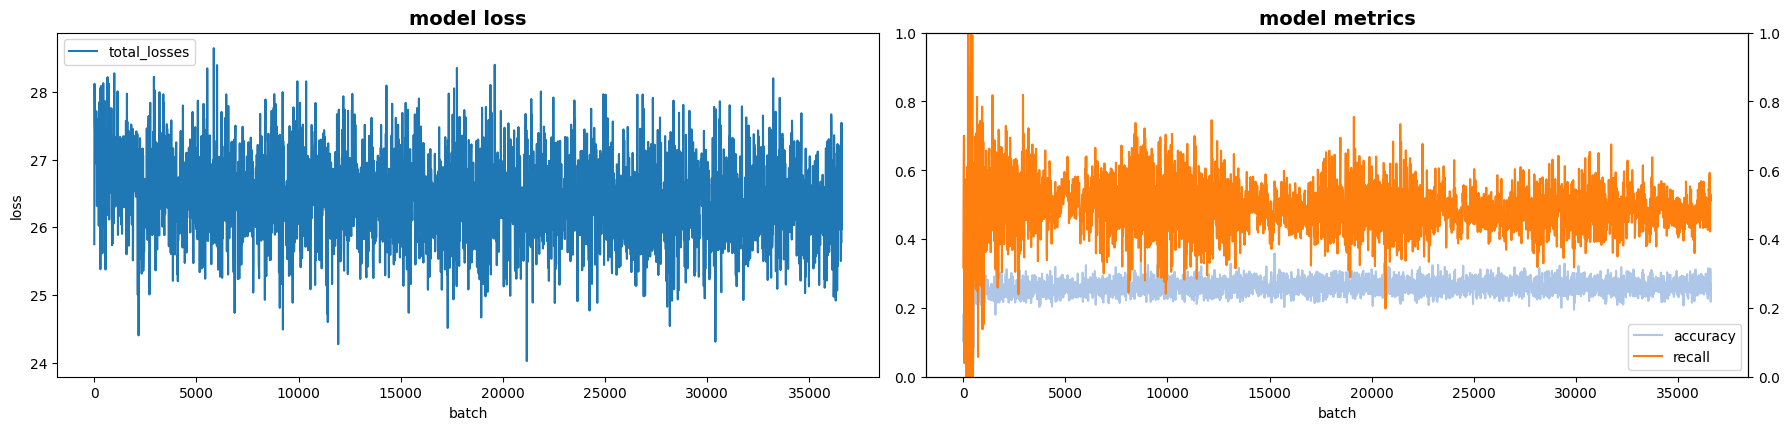

model 0  Step: 939ms    | Loss: 26.285 | accuracy: 27.227% , recall: 49.868%  | lr: 1.936e-05  | epoch: 3  ( 8910/9233 )
model 0  Step: 828ms    | Loss: 26.560 | accuracy: 29.201% , recall: 53.120%  | lr: 1.946e-05  | epoch: 3  ( 8920/9233 )
model 0  Step: 839ms    | Loss: 26.829 | accuracy: 26.516% , recall: 49.689%  | lr: 1.957e-05  | epoch: 3  ( 8930/9233 )
model 0  Step: 796ms    | Loss: 27.048 | accuracy: 28.429% , recall: 54.322%  | lr: 1.968e-05  | epoch: 3  ( 8940/9233 )
model 0  Step: 814ms    | Loss: 26.829 | accuracy: 27.221% , recall: 55.884%  | lr: 1.979e-05  | epoch: 3  ( 8950/9233 )
model 0  Step: 836ms    | Loss: 26.478 | accuracy: 25.701% , recall: 54.238%  | lr: 1.989e-05  | epoch: 3  ( 8960/9233 )
model 0  Step: 913ms    | Loss: 26.732 | accuracy: 23.692% , recall: 46.967%  | lr: 2.000e-05  | epoch: 3  ( 8970/9233 )
model 0  Step: 777ms    | Loss: 26.320 | accuracy: 25.788% , recall: 56.490%  | lr: 2.011e-05  | epoch: 3  ( 8980/9233 )
model 0  Step: 841ms    | Loss: 

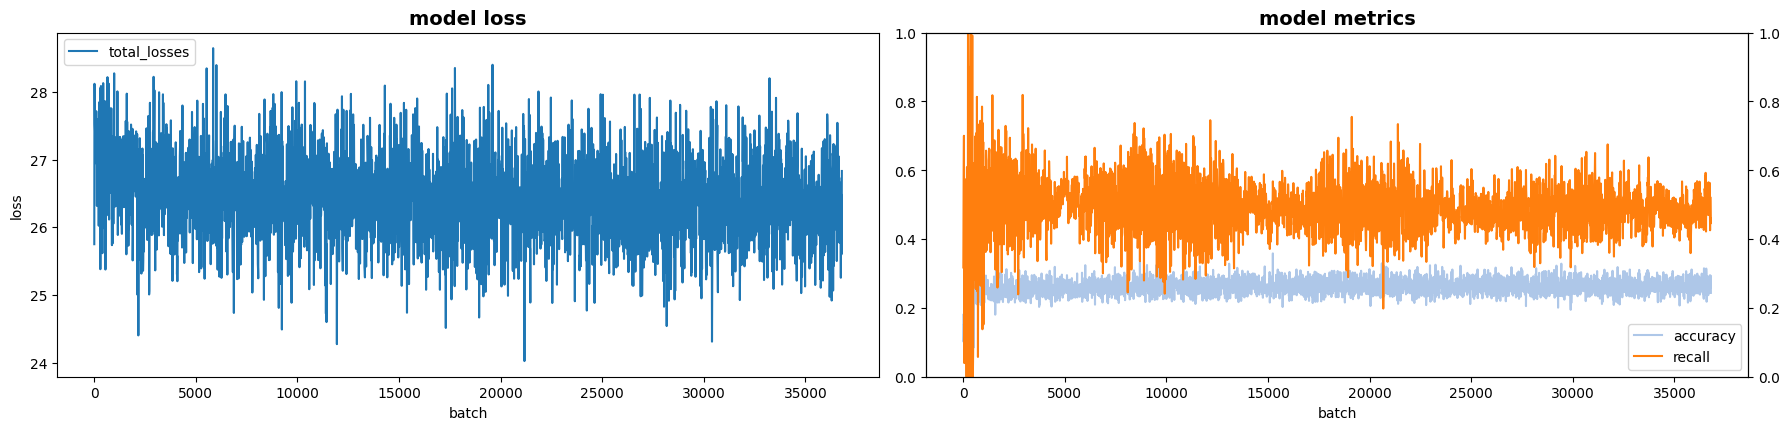

model 0  Step: 951ms    | Loss: 26.644 | accuracy: 27.342% , recall: 50.145%  | lr: 2.156e-05  | epoch: 3  ( 9110/9233 )
model 0  Step: 820ms    | Loss: 26.178 | accuracy: 29.250% , recall: 52.975%  | lr: 2.168e-05  | epoch: 3  ( 9120/9233 )
model 0  Step: 849ms    | Loss: 26.642 | accuracy: 24.895% , recall: 51.025%  | lr: 2.179e-05  | epoch: 3  ( 9130/9233 )
model 0  Step: 827ms    | Loss: 25.715 | accuracy: 27.410% , recall: 54.933%  | lr: 2.191e-05  | epoch: 3  ( 9140/9233 )
model 0  Step: 794ms    | Loss: 25.720 | accuracy: 26.859% , recall: 48.248%  | lr: 2.202e-05  | epoch: 3  ( 9150/9233 )
model 0  Step: 839ms    | Loss: 25.975 | accuracy: 24.107% , recall: 43.224%  | lr: 2.214e-05  | epoch: 3  ( 9160/9233 )
model 0  Step: 912ms    | Loss: 25.219 | accuracy: 26.859% , recall: 43.647%  | lr: 2.225e-05  | epoch: 3  ( 9170/9233 )
model 0  Step: 773ms    | Loss: 26.274 | accuracy: 24.391% , recall: 43.349%  | lr: 2.237e-05  | epoch: 3  ( 9180/9233 )
model 0  Step: 844ms    | Loss: 

In [45]:
plan.start_now()